# Technical Indicators

## 0. Imports and Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os

### a. Import Data

In [2]:
data = pd.read_csv("cleaned_merged_data-sample-with-sentiment-v02.csv")
columns = ['Datetime', 'score_int', 'total_tweets', 'share_of_positive', 'share_of_negative']
sentimental_data = data[columns]

In [3]:
df = data.copy()
sent_df = sentimental_data.copy()

### c. Formating

In [4]:
def df_formating(formated_df, date_column, open_column, high_column, low_column, adj_close_column, volume_column):
    """
    Preprocess a DataFrame by renaming columns, setting columns to float64,
    dropping unnecessary columns, setting the 'date' column to datetime type,
    and setting the 'date' column as the index.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - define which columns of df refere to which price data

    Returns:
    - pd.DataFrame: Processed DataFrame.
    """
    # Step 1: Rename columns
    formated_df = formated_df.rename(columns={
        date_column: 'Date',
        open_column: 'Open',
        high_column: 'High',
        low_column: 'Low',
        adj_close_column: 'Adj_Close',
        volume_column: 'Volume'
    })

    # Step 2: Set columns to float64
    formated_df = formated_df.astype({'Open': 'float32', 'High': 'float32', 'Low': 'float32', 'Adj_Close': 'float32', 'Volume': 'float32'})

    # Step 3: Drop all other columns
    columns_to_keep = ['Date', 'Open', 'High', 'Low', 'Adj_Close', 'Volume']
    formated_df = formated_df[columns_to_keep]

    # Step 4: Set 'date' column to datetime type
    formated_df['Date'] = pd.to_datetime(formated_df['Date'], format='mixed')

    # Step 5: Set 'date' column as the index
    formated_df.set_index('Date', inplace=True)

    return formated_df
    

In [5]:
def sent_df_formating(sent_df, date_column, score_int, total_tweets, share_of_positive, share_of_negative):
    """
    Preprocess a DataFrame by renaming columns, setting columns to float64,
    dropping unnecessary columns, setting the 'date' column to datetime type,
    and setting the 'date' column as the index.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - define which columns of df refere to which price data

    Returns:
    - pd.DataFrame: Processed DataFrame.
    """
    # Step 1: Rename columns
    sent_df = sent_df.rename(columns={
        date_column: 'Date',
        score_int: 'Score',
        total_tweets: 'Total',
        share_of_positive: 'Positive',
        share_of_negative: 'Negative'
    })

    # Step 2: Set columns to float64
    sent_df = sent_df.astype({'Score': 'float32', 'Total': 'float32', 'Positive': 'float32', 'Negative': 'float32'})

    # Step 3: Set 'date' column to datetime type
    sent_df['Date'] = pd.to_datetime(sent_df['Date'], format='mixed')

    # Step 4: Set 'date' column as the index
    sent_df.set_index('Date', inplace=True)

    # Step 4: Drop Nan rows
    sent_df = sent_df.dropna()
    
    return sent_df

In [6]:
def labeling_df(labeled_df):
    # Create a new column 'Label' and initialize with 0 (constant)
    labeled_df['Label'] = 0
    
    # Label -1 (down) where 'Open' is higher than 'Adj Close'
    labeled_df.loc[labeled_df['Open'] > labeled_df['Adj_Close'], 'Label'] = 0

    # Label +1 (up) where 'Open' is lower than 'Adj Close'
    labeled_df.loc[labeled_df['Open'] < labeled_df['Adj_Close'], 'Label'] = 1

    return labeled_df

In [7]:
def merge_df(df, sent_df):
    
    # Merge two df on their indexes
    merged_df = pd.merge(df, sent_df, left_index=True, right_index=True)
    
    return merged_df

In [8]:
formated_df = df_formating(df, 'Datetime', 'Open-TSLA', 'High-TSLA', 'Low-TSLA', 'Adj Close-TSLA', 'Volume-TSLA')
formated_sent_df = sent_df_formating(sent_df, 'Datetime', 'score_int', 'total_tweets', 'share_of_positive', 'share_of_negative')
labeled_formated_df = labeling_df(formated_df)
merged_df = merge_df(labeled_formated_df, formated_sent_df)
merged_df

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative
Date,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909


## 1. Feature Engineering

### A. Moving Average (MA(5) & MA(20))

In [9]:
def moving_averages(df, column_name='Adj_Close', window_sizes=[5, 20]):
    """
    Add Moving Averages (MA) columns to the DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which moving averages are calculated.
    - window_sizes (list): List of window sizes for moving averages. Default is [5, 20].

    Returns:
    - pd.DataFrame: DataFrame with added MA columns.
    """
    for window_size in window_sizes:
        ma_column_name = f'MA_{window_size}'
        df[ma_column_name] = df[column_name].rolling(window=window_size).mean()

    return df

In [10]:
moving_averages(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,MA_5,MA_20
Date,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,NaN,NaN
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,NaN,NaN
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,NaN,NaN
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,NaN,NaN
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,379.360010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,280.346704,280.185275
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,277.257007,279.713780
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,273.297003,279.282774


### B. Bollinger Band (BB up & BB down)

In [11]:
def bollinger_bands(df, column_name='Adj_Close', window_size=20, num_std_dev=2):
    """
    Calculate Bollinger Bands for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which Bollinger Bands are calculated.
    - window_size (int): Window size for the moving average. Default is 20.
    - num_std_dev (int): Number of standard deviations for the upper and lower bands. Default is 2.

    Returns:
    - pd.DataFrame: DataFrame with added columns for Bollinger Bands (BB up, BB down).
    """
    # Calculate the rolling mean (middle band)
    df['MiddleBand'] = df[column_name].rolling(window=window_size).mean()

    # Calculate the rolling standard deviation
    df['StdDev'] = df[column_name].rolling(window=window_size).std()

    # Calculate Bollinger Bands
    df['BB_Up'] = df['MiddleBand'] + num_std_dev * df['StdDev']
    df['BB_Down'] = df['MiddleBand'] - num_std_dev * df['StdDev']

    # Drop intermediate columns
    df.drop(['MiddleBand', 'StdDev'], axis=1, inplace=True)

    return df

In [12]:
bollinger_bands(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,MA_5,MA_20,BB_Up,BB_Down
Date,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,NaN,NaN,NaN,NaN
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,NaN,NaN,NaN,NaN
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,NaN,NaN,NaN,NaN
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,NaN,NaN,NaN,NaN
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,379.360010,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,280.346704,280.185275,289.308075,271.062476
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,277.257007,279.713780,290.294435,269.133126
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,273.297003,279.282774,291.101124,267.464425


### C. Relative Difference in the Percentage of the price (RDP(1))

In [13]:
def rdp(df, column_name='Adj_Close'):
    """
    Calculate Relative Difference in the Percentage of the price (RDP(1)) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which RDP(1) is calculated.

    Returns:
    - pd.DataFrame: DataFrame with an added column for RDP(1).
    """
    # Calculate RDP(1)
    df['RDP_1'] = df[column_name].pct_change() * 100

    return df

In [14]:
rdp(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,MA_5,MA_20,BB_Up,BB_Down,RDP_1
Date,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,NaN,NaN,NaN,NaN,-2.723438
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.010169
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,NaN,NaN,NaN,NaN,-0.426024
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,379.360010,NaN,NaN,NaN,1.067448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,280.346704,280.185275,289.308075,271.062476,-0.881630
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,277.257007,279.713780,290.294435,269.133126,-0.882077
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,273.297003,279.282774,291.101124,267.464425,-0.167912


### D. Bias Ratio (BIAS(6), BIAS(12) & BIAS(24))

In [15]:
def bias(df, column_name='Adj_Close', ma_windows=[6, 12, 24]):
    """
    Calculate Bias Ratios (BIAS) for specified moving average windows for a column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which BIAS is calculated.
    - ma_windows (list): List of moving average window sizes. Default is [6, 12, 24].

    Returns:
    - pd.DataFrame: DataFrame with added columns for BIAS(6), BIAS(12), and BIAS(24).
    """
    for window_size in ma_windows:
        ma_column_name = f'MA_{window_size}'
        bias_column_name = f'BIAS_{window_size}'

        # Calculate the moving average
        df[ma_column_name] = df[column_name].rolling(window=window_size).mean()

        # Calculate BIAS
        df[bias_column_name] = ((df[column_name] - df[ma_column_name]) / df[ma_column_name]) * 100

        # Drop intermediate columns
        df.drop(ma_column_name, axis=1, inplace=True)

    return df

In [16]:
bias(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,MA_5,MA_20,BB_Up,BB_Down,RDP_1,BIAS_6,BIAS_12,BIAS_24
Date,,,,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,NaN,NaN,NaN,NaN,-2.723438,NaN,NaN,NaN
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.010169,NaN,NaN,NaN
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,NaN,NaN,NaN,NaN,-0.426024,NaN,NaN,NaN
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,379.360010,NaN,NaN,NaN,1.067448,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,280.346704,280.185275,289.308075,271.062476,-0.881630,-3.733241,-3.866743,-3.200636
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,277.257007,279.713780,290.294435,269.133126,-0.882077,-3.697208,-4.398604,-3.953059
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,273.297003,279.282774,291.101124,267.464425,-0.167912,-2.934700,-4.229376,-4.009411


### E. Relative Strength Index (RSI)

In [17]:
def rsi(df, column_name='Adj_Close', window=14):
    """
    Calculate the Relative Strength Index (RSI) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which RSI is calculated. Default is 'Close'.
    - window (int): Window size for RSI calculation. Default is 14.

    Returns:
    - pd.DataFrame: DataFrame with an added column for RSI.
    """
    # Calculate daily price changes
    df['PriceChange'] = df[column_name].diff()

    # Calculate the average gain and average loss over the specified window
    df['Gain'] = df['PriceChange'].apply(lambda x: x if x > 0 else 0).rolling(window=window, min_periods=1).mean()
    df['Loss'] = -df['PriceChange'].apply(lambda x: x if x < 0 else 0).rolling(window=window, min_periods=1).mean()

    # Calculate relative strength (RS)
    df['RS'] = df['Gain'] / df['Loss']

    # Calculate RSI
    df['RSI'] = 100 - (100 / (1 + df['RS']))

    # Drop intermediate columns
    df.drop(['PriceChange', 'Gain', 'Loss', 'RS'], axis=1, inplace=True)

    return df

In [18]:
rsi(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,MA_5,MA_20,BB_Up,BB_Down,RDP_1,BIAS_6,BIAS_12,BIAS_24,RSI
Date,,,,,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,NaN,NaN,NaN,NaN,-2.723438,NaN,NaN,NaN,0.000000
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.010169,NaN,NaN,NaN,0.361775
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,NaN,NaN,NaN,NaN,-0.426024,NaN,NaN,NaN,0.314141
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,379.360010,NaN,NaN,NaN,1.067448,NaN,NaN,NaN,24.963853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,280.346704,280.185275,289.308075,271.062476,-0.881630,-3.733241,-3.866743,-3.200636,43.548223
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,277.257007,279.713780,290.294435,269.133126,-0.882077,-3.697208,-4.398604,-3.953059,27.409629
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,273.297003,279.282774,291.101124,267.464425,-0.167912,-2.934700,-4.229376,-4.009411,31.167846


### F. Exponential Moving Average (EMA(12) & EMA(26))

In [19]:
def ema(df, column_name='Adj_Close', ema_short=12, ema_long=26):
    """
    Calculate Exponential Moving Averages (EMA) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which EMA is calculated. Default is 'Close'.
    - ema_short (int): Short-term EMA window size. Default is 12.
    - ema_long (int): Long-term EMA window size. Default is 26.

    Returns:
    - pd.DataFrame: DataFrame with added columns for EMA(12) and EMA(26).
    """
    # Calculate EMA(12)
    df['EMA_12'] = df[column_name].ewm(span=ema_short, adjust=False).mean()

    # Calculate EMA(26)
    df['EMA_26'] = df[column_name].ewm(span=ema_long, adjust=False).mean()

    return df

In [20]:
ema(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,...,MA_20,BB_Up,BB_Down,RDP_1,BIAS_6,BIAS_12,BIAS_24,RSI,EMA_12,EMA_26
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,387.623322,387.623322
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,...,NaN,NaN,NaN,-2.723438,NaN,NaN,NaN,0.000000,385.999218,386.841346
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,...,NaN,NaN,NaN,0.010169,NaN,NaN,NaN,0.361775,384.630874,386.120134
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,...,NaN,NaN,NaN,-0.426024,NaN,NaN,NaN,0.314141,383.225880,385.333340
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,...,NaN,NaN,NaN,1.067448,NaN,NaN,NaN,24.963853,382.653696,384.901735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,...,280.185275,289.308075,271.062476,-0.881630,-3.733241,-3.866743,-3.200636,43.548223,280.129088,282.584802
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,...,279.713780,290.294435,269.133126,-0.882077,-3.697208,-4.398604,-3.953059,27.409629,278.263074,281.504446
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,...,279.282774,291.101124,267.464425,-0.167912,-2.934700,-4.229376,-4.009411,31.167846,276.614907,280.470783


### G. Moving Average Convergence/Divergence (MACD)

In [21]:
def macd(df, column_name='Adj_Close', ema_short=12, ema_long=26, signal_period=9):
    """
    Calculate Moving Average Convergence Divergence (MACD) and its signal line for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which MACD is calculated. Default is 'Close'.
    - ema_short (int): Short-term EMA window size. Default is 12.
    - ema_long (int): Long-term EMA window size. Default is 26.
    - signal_period (int): Signal line EMA window size. Default is 9.

    Returns:
    - pd.DataFrame: DataFrame with added columns for MACD, Signal Line, and MACD Histogram.
    """
    # Calculate short-term EMA
    df['EMA_short'] = df[column_name].ewm(span=ema_short, adjust=False).mean()

    # Calculate long-term EMA
    df['EMA_long'] = df[column_name].ewm(span=ema_long, adjust=False).mean()

    # Calculate MACD Line
    df['DIF'] = df['EMA_short'] - df['EMA_long']

    # Calculate Signal Line
    df['Signal_Line'] = df['DIF'].ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    df['OSC'] = df['DIF'] - df['Signal_Line']

    # Drop intermediate columns
    df.drop(['EMA_short', 'EMA_long'], axis=1, inplace=True)

    return df

In [22]:
macd(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,...,RDP_1,BIAS_6,BIAS_12,BIAS_24,RSI,EMA_12,EMA_26,DIF,Signal_Line,OSC
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,387.623322,387.623322,0.000000,0.000000,0.000000
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,...,-2.723438,NaN,NaN,NaN,0.000000,385.999218,386.841346,-0.842128,-0.168426,-0.673702
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,...,0.010169,NaN,NaN,NaN,0.361775,384.630874,386.120134,-1.489260,-0.432592,-1.056667
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,...,-0.426024,NaN,NaN,NaN,0.314141,383.225880,385.333340,-2.107460,-0.767566,-1.339894
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,...,1.067448,NaN,NaN,NaN,24.963853,382.653696,384.901735,-2.248039,-1.063661,-1.184379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,...,-0.881630,-3.733241,-3.866743,-3.200636,43.548223,280.129088,282.584802,-2.455714,-2.395471,-0.060243
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,...,-0.882077,-3.697208,-4.398604,-3.953059,27.409629,278.263074,281.504446,-3.241372,-2.564651,-0.676721
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,...,-0.167912,-2.934700,-4.229376,-4.009411,31.167846,276.614907,280.470783,-3.855876,-2.822896,-1.032979


### H. Psychological Line (PSY(12) & PSY(24))

In [23]:
def psy(df, column_name='Adj_Close', psy_short=12, psy_long=24):
    """
    Calculate Psychological Line (PSY) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which PSY is calculated. Default is 'Close'.
    - psy_short (int): Short-term PSY window size. Default is 12.
    - psy_long (int): Long-term PSY window size. Default is 24.

    Returns:
    - pd.DataFrame: DataFrame with added columns for PSY(12) and PSY(24).
    """
    # Calculate the percentage of days where the closing price is higher than the previous day's closing price
    df['PriceUp'] = df[column_name].diff() > 0

    # Calculate PSY(12)
    df['PSY_12'] = df['PriceUp'].rolling(window=psy_short).mean() * 100

    # Calculate PSY(24)
    df['PSY_24'] = df['PriceUp'].rolling(window=psy_long).mean() * 100

    # Drop intermediate columns
    df.drop(['PriceUp'], axis=1, inplace=True)

    return df

In [24]:
psy(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,...,BIAS_12,BIAS_24,RSI,EMA_12,EMA_26,DIF,Signal_Line,OSC,PSY_12,PSY_24
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,...,NaN,NaN,NaN,387.623322,387.623322,0.000000,0.000000,0.000000,NaN,NaN
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,...,NaN,NaN,0.000000,385.999218,386.841346,-0.842128,-0.168426,-0.673702,NaN,NaN
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,...,NaN,NaN,0.361775,384.630874,386.120134,-1.489260,-0.432592,-1.056667,NaN,NaN
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,...,NaN,NaN,0.314141,383.225880,385.333340,-2.107460,-0.767566,-1.339894,NaN,NaN
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,...,NaN,NaN,24.963853,382.653696,384.901735,-2.248039,-1.063661,-1.184379,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,...,-3.866743,-3.200636,43.548223,280.129088,282.584802,-2.455714,-2.395471,-0.060243,50.0,54.166667
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,...,-4.398604,-3.953059,27.409629,278.263074,281.504446,-3.241372,-2.564651,-0.676721,50.0,50.000000
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,...,-4.229376,-4.009411,31.167846,276.614907,280.470783,-3.855876,-2.822896,-1.032979,50.0,50.000000


### I. Williams %R (WMS%R)

In [25]:
def williams_percent_r(df, high_column='High', low_column='Low', adj_close_column='Adj_Close', window=14):
    """
    Calculate Williams %R for a specified high, low, and close columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - high_column (str): Name of the column containing high prices. Default is 'High'.
    - low_column (str): Name of the column containing low prices. Default is 'Low'.
    - adj_close_column (str): Name of the column containing close prices. Default is 'Close'.
    - window (int): Window size for Williams %R calculation. Default is 14.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Williams %R.
    """
    # Calculate highest high and lowest low over the specified window
    df['HH'] = df[high_column].rolling(window=window).max()
    df['LL'] = df[low_column].rolling(window=window).min()

    # Calculate Williams %R
    df['Williams_%R'] = (df['HH'] - df[adj_close_column]) / (df['HH'] - df['LL']) * -100

    # Drop intermediate columns
    df.drop(['HH', 'LL'], axis=1, inplace=True)

    return df

In [26]:
williams_percent_r(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,...,BIAS_24,RSI,EMA_12,EMA_26,DIF,Signal_Line,OSC,PSY_12,PSY_24,Williams_%R
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,...,NaN,NaN,387.623322,387.623322,0.000000,0.000000,0.000000,NaN,NaN,NaN
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,...,NaN,0.000000,385.999218,386.841346,-0.842128,-0.168426,-0.673702,NaN,NaN,NaN
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,...,NaN,0.361775,384.630874,386.120134,-1.489260,-0.432592,-1.056667,NaN,NaN,NaN
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,...,NaN,0.314141,383.225880,385.333340,-2.107460,-0.767566,-1.339894,NaN,NaN,NaN
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,...,NaN,24.963853,382.653696,384.901735,-2.248039,-1.063661,-1.184379,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,...,-3.200636,43.548223,280.129088,282.584802,-2.455714,-2.395471,-0.060243,50.0,54.166667,-93.171910
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,...,-3.953059,27.409629,278.263074,281.504446,-3.241372,-2.564651,-0.676721,50.0,50.000000,-95.541354
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,...,-4.009411,31.167846,276.614907,280.470783,-3.855876,-2.822896,-1.032979,50.0,50.000000,-94.243543


### J. Stochastic Oscillator (Stochastic%K & Stochastic%D)

In [27]:
def stochastic_oscillator(df, high_column='High', low_column='Low', adj_close_column='Adj_Close', k_window=14, d_window=3):
    """
    Calculate Stochastic Oscillator (%K and %D) for specified high, low, and close columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - high_column (str): Name of the column containing high prices. Default is 'High'.
    - low_column (str): Name of the column containing low prices. Default is 'Low'.
    - close_column (str): Name of the column containing close prices. Default is 'Close'.
    - k_window (int): Window size for %K calculation. Default is 14.
    - d_window (int): Window size for %D calculation. Default is 3.

    Returns:
    - pd.DataFrame: DataFrame with added columns for Stochastic %K and %D.
    """
    # Calculate lowest low and highest high over the specified window
    df['LL'] = df[low_column].rolling(window=k_window).min()
    df['HH'] = df[high_column].rolling(window=k_window).max()

    # Calculate Stochastic %K
    df['Stochastic_%K'] = ((df[adj_close_column] - df['LL']) / (df['HH'] - df['LL'])) * 100

    # Calculate Stochastic %D (3-day simple moving average of %K)
    df['Stochastic_%D'] = df['Stochastic_%K'].rolling(window=d_window).mean()

    # Drop intermediate columns
    df.drop(['LL', 'HH'], axis=1, inplace=True)

    return df

In [28]:
stochastic_oscillator(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,...,EMA_12,EMA_26,DIF,Signal_Line,OSC,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,...,387.623322,387.623322,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,...,385.999218,386.841346,-0.842128,-0.168426,-0.673702,NaN,NaN,NaN,NaN,NaN
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,...,384.630874,386.120134,-1.489260,-0.432592,-1.056667,NaN,NaN,NaN,NaN,NaN
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,...,383.225880,385.333340,-2.107460,-0.767566,-1.339894,NaN,NaN,NaN,NaN,NaN
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,...,382.653696,384.901735,-2.248039,-1.063661,-1.184379,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,...,280.129088,282.584802,-2.455714,-2.395471,-0.060243,50.0,54.166667,-93.171910,6.828090,38.773714
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,...,278.263074,281.504446,-3.241372,-2.564651,-0.676721,50.0,50.000000,-95.541354,4.458646,10.050782
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,...,276.614907,280.470783,-3.855876,-2.822896,-1.032979,50.0,50.000000,-94.243543,5.756457,5.681064


### K. Percentage of Price Change (PROC)

In [29]:
def proc(df, column_name='Adj_Close', window=1):
    """
    Calculate Percentage of Price Change (PROC) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which PROC is calculated. Default is 'Close'.
    - window (int): Window size for PROC calculation. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for PROC.
    """
    # Calculate the percentage change in price using rolling window
    df['PROC'] = df[column_name].pct_change().rolling(window=window).mean() * 100

    return df

In [30]:
proc(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,...,EMA_26,DIF,Signal_Line,OSC,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,...,387.623322,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,...,386.841346,-0.842128,-0.168426,-0.673702,NaN,NaN,NaN,NaN,NaN,-2.723438
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,...,386.120134,-1.489260,-0.432592,-1.056667,NaN,NaN,NaN,NaN,NaN,0.010169
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,...,385.333340,-2.107460,-0.767566,-1.339894,NaN,NaN,NaN,NaN,NaN,-0.426024
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,...,384.901735,-2.248039,-1.063661,-1.184379,NaN,NaN,NaN,NaN,NaN,1.067448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,...,282.584802,-2.455714,-2.395471,-0.060243,50.0,54.166667,-93.171910,6.828090,38.773714,-0.881630
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,...,281.504446,-3.241372,-2.564651,-0.676721,50.0,50.000000,-95.541354,4.458646,10.050782,-0.882077
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,...,280.470783,-3.855876,-2.822896,-1.032979,50.0,50.000000,-94.243543,5.756457,5.681064,-0.167912


### L. Momentum (MO(1))

In [31]:
def momentum(df, column_name='Adj_Close', window=1):
    """
    Calculate Momentum (MO) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which Momentum is calculated. Default is 'Close'.
    - window (int): Window size for Momentum calculation. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Momentum.
    """
    # Calculate the difference in price over the specified window
    df['Momentum'] = df[column_name].diff(window)

    return df

In [32]:
momentum(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,...,DIF,Signal_Line,OSC,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC,Momentum
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,...,-0.842128,-0.168426,-0.673702,NaN,NaN,NaN,NaN,NaN,-2.723438,-10.556671
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,...,-1.489260,-0.432592,-1.056667,NaN,NaN,NaN,NaN,NaN,0.010169,0.038330
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,...,-2.107460,-0.767566,-1.339894,NaN,NaN,NaN,NaN,NaN,-0.426024,-1.606567
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,...,-2.248039,-1.063661,-1.184379,NaN,NaN,NaN,NaN,NaN,1.067448,4.008270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,...,-2.455714,-2.395471,-0.060243,50.0,54.166667,-93.171910,6.828090,38.773714,-0.881630,-2.404999
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,...,-3.241372,-2.564651,-0.676721,50.0,50.000000,-95.541354,4.458646,10.050782,-0.882077,-2.385010
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,...,-3.855876,-2.822896,-1.032979,50.0,50.000000,-94.243543,5.756457,5.681064,-0.167912,-0.450012


### M. First-Order Lag (LAG(1))

In [33]:
def first_order_lag(df, column_name='Adj_Close', lag=1):
    """
    Calculate First-Order Lag (LAG(1)) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which the lag is calculated. Default is 'Close'.
    - lag (int): Number of periods to lag. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for the First-Order Lag.
    """
    # Calculate the First-Order Lag using the shift() method
    df[f'LAG_{lag}'] = df[column_name].shift(lag)

    return df

In [34]:
first_order_lag(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,...,Signal_Line,OSC,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC,Momentum,LAG_1
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,...,-0.168426,-0.673702,NaN,NaN,NaN,NaN,NaN,-2.723438,-10.556671,387.623322
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,...,-0.432592,-1.056667,NaN,NaN,NaN,NaN,NaN,0.010169,0.038330,377.066650
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,...,-0.767566,-1.339894,NaN,NaN,NaN,NaN,NaN,-0.426024,-1.606567,377.104980
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,...,-1.063661,-1.184379,NaN,NaN,NaN,NaN,NaN,1.067448,4.008270,375.498413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,...,-2.395471,-0.060243,50.0,54.166667,-93.171910,6.828090,38.773714,-0.881630,-2.404999,272.790009
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,...,-2.564651,-0.676721,50.0,50.000000,-95.541354,4.458646,10.050782,-0.882077,-2.385010,270.385010
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,...,-2.822896,-1.032979,50.0,50.000000,-94.243543,5.756457,5.681064,-0.167912,-0.450012,268.000000


### N. Trading Volume (VOL)

In [35]:
def trading_volume(df, volume_column='Volume'):
    """
    Calculate Trading Volume (VOL) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - volume_column (str): Name of the column containing trading volume. Default is 'Volume'.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Trading Volume.
    """
    df['VOL'] = df[volume_column]

    return df

In [36]:
trading_volume(merged_df)

,Open,High,Low,Adj_Close,Volume,Label,Score,Total,Positive,Negative,...,OSC,PSY_12,PSY_24,Williams_%R,Stochastic_%K,Stochastic_%D,PROC,Momentum,LAG_1,VOL
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-30 15:00:00,381.456665,389.333344,381.334717,387.623322,6562747.0,1,0.0,11.0,0.000000,0.000000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6562747.0
2021-11-30 16:00:00,387.766693,388.833344,375.333344,377.066650,5269359.0,0,-1.0,7.0,0.000000,0.000000,...,-0.673702,NaN,NaN,NaN,NaN,NaN,-2.723438,-10.556671,387.623322,5269359.0
2021-11-30 17:00:00,376.839996,378.619995,372.666656,377.104980,3247689.0,1,-2.0,7.0,0.000000,0.000000,...,-1.056667,NaN,NaN,NaN,NaN,NaN,0.010169,0.038330,377.066650,3247689.0
2021-11-30 18:00:00,376.963348,380.649994,375.066650,375.498413,2089177.0,0,0.0,7.0,0.142857,-0.142857,...,-1.339894,NaN,NaN,NaN,NaN,NaN,-0.426024,-1.606567,377.104980,2089177.0
2021-11-30 19:00:00,375.510010,381.189972,375.176666,379.506683,1840965.0,1,-2.0,5.0,0.000000,0.000000,...,-1.184379,NaN,NaN,NaN,NaN,NaN,1.067448,4.008270,375.498413,1840965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 16:00:00,272.820007,273.760010,269.649994,270.385010,7964963.0,0,0.0,6.0,0.000000,0.000000,...,-0.060243,50.0,54.166667,-93.171910,6.828090,38.773714,-0.881630,-2.404999,272.790009,7964963.0
2022-09-29 17:00:00,270.329987,271.149994,267.019989,268.000000,8794413.0,0,-1.0,8.0,0.000000,0.000000,...,-0.676721,50.0,50.000000,-95.541354,4.458646,10.050782,-0.882077,-2.385010,270.385010,8794413.0
2022-09-29 18:00:00,268.000214,268.869995,266.239807,267.549988,8637437.0,0,-2.0,11.0,0.090909,-0.090909,...,-1.032979,50.0,50.000000,-94.243543,5.756457,5.681064,-0.167912,-0.450012,268.000000,8637437.0


## 2. Preprocessing

### a. Removing columns and rows

In [37]:
def drop_columns(df, columns_to_drop=['Open', 'High', 'Low', 'Adj_Close', 'Volume']):
    """
    Drop specified columns from a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - columns_to_drop (list): List of column names to drop. Default is ['Open', 'High', 'Low', 'Adj_Close', 'Volume'].

    Returns:
    - pd.DataFrame: DataFrame with specified columns dropped.
    """
    # Drop specified columns
    df = df.drop(columns=columns_to_drop, errors='ignore')

    return df

In [38]:
def drop_rows(df):
    """
    Drop all rows with NaN values from a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: DataFrame with NaN rows dropped.
    - list: List of indices corresponding to dropped rows.
    """
    # Drop rows with NaN values
    cleaned_df = df.dropna()

    return cleaned_df

In [39]:
clean_merged_df = drop_columns(merged_df)
clean_merged_df = drop_rows(clean_merged_df)

### b. Scaling

In [40]:
def scale_dataframe(df):
    """
    Scale a DataFrame using Standard scaling.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: Scaled DataFrame.
    """
    # Scale the selected columns
    scaler = StandardScaler()

    index_column = df.index
    
    date_column = df['Label']
    int_df = df.drop(columns=['Label'])
    
    columns_to_scale = int_df.columns
    
    scaled_df = pd.DataFrame(scaler.fit_transform(int_df), columns=columns_to_scale)
    scaled_df.index = index_column
    scaled_df['Label'] = date_column
    
    return scaled_df

In [41]:
scaled_clean_merged_df = scale_dataframe(clean_merged_df)

### c. Train Test Split

In [42]:
def train_test_split(df, test_size=0.2):
    """
    Split a time series dataset into training, testing, and validation sets.

    Parameters:
    - df: NumPy array or matrix, the input time series dataset.
    - test_size: Float, the proportion of the dataset to include in the test split.
    - val_size: Float, the proportion of the dataset to include in the validation split.

    Returns:
    - df_train, df_test: Pandas arrays, representing features and target values for each set.
    """
    
    # Extract index number of splitting points
    len_df = len(df)
    index_1 = round(len_df*(1-(test_size)))
    index_2 = index_1 +1

    # Extract values at previously calculated splitting points
    date_1 = df.index[index_1]
    date_2 = df.index[index_2]

    # Construct train_df, val_df and test_df
    df_train = df[:date_1]
    df_test = df[date_2:]
    
    return df_train, df_test

In [43]:
split_scaled_clean_merged_df = train_test_split(scaled_clean_merged_df)

### d. Reshape Matrix

In [44]:
def input_matrix_split_X_y(df, window_size=5):
    """
    Reshape a DataFrame into a 3D NumPy arrays (num_observations, window_size, num_features)

    Parameters:
    - df: DataFrame with a list of time series data
    - sequence_length: the number of time steps to consider for each observation

    Returns:
    - X, y: a 3D NumPy arrays, one for the features and one for the lables
    """
    df_np = df.to_numpy()
    X = []
    y = []
    
    df_X = df.drop('Label', axis=1)
    df_y = df['Label']

    for i in range(len(df_np)-(window_size)):
        row = df_X[i:i+window_size]
        X.append(row)
        label = df_y[i+(window_size)]
        y.append(label)

    X = np.array(X)
    y = np.array(y)
    y = np.expand_dims(y, axis=-1)
    
    return X, y

In [45]:
X_train, y_train = input_matrix_split_X_y(split_scaled_clean_merged_df[0], 5)
X_test, y_test = input_matrix_split_X_y(split_scaled_clean_merged_df[1], 5)
X_train.shape, y_train.shape

/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_62963/118946909.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]
/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_62963/118946909.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]


((986, 5, 27), (986, 1))

## 3. Basic Model

In [46]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

### a. Initialize Model

In [47]:
def initialize_model(window_size=5, optimizer_name='adam'):
    
    #############################
    #  1 - Model architecture   #
    ############################# 
    
    # [1, 5] layers
    # nodes per layer [30, 70]
    # activation function: relu
    # optimizer: Adam
    # learning rate = [0.001, 0.1]
    
    model = models.Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(window_size, X_train.shape[-1])))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    
    
    # $CHALLENGIFY_END
    
    #############################
    #  2 - Optimization Method  #
    #############################
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer_name, 
                  metrics=['accuracy']) 

    return model 

model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             23552     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 dense (Dense)               (None, 5, 1)              65        
                                                                 
Total params: 23617 (92.25 KB)
Trainable params: 23617 (92.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### b. Train Model

In [48]:
# batch size = [64, 128]
# epochs = [50, 80]

def train_model():
    
    es = EarlyStopping(patience=5, restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                        validation_split=0.1,
                        batch_size=64,
                        epochs=100, 
                        callbacks=[es],
                        verbose=1)

    return history

history = train_model()

Epoch 1/100
14/14 [==============================] - 1s 18ms/step - loss: 0.7011 - accuracy: 0.4963 - val_loss: 0.6904 - val_accuracy: 0.5778
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.5125 - val_loss: 0.6971 - val_accuracy: 0.4707
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5333 - val_loss: 0.6986 - val_accuracy: 0.4566
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5443 - val_loss: 0.7006 - val_accuracy: 0.4444
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.5493 - val_loss: 0.6986 - val_accuracy: 0.4869
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5421 - val_loss: 0.7076 - val_accuracy: 0.4162


In [49]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

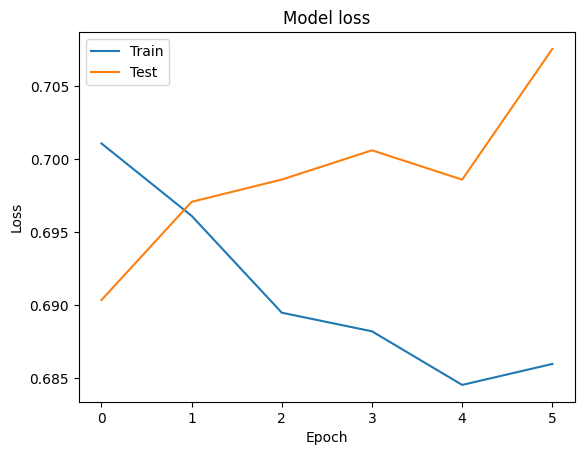

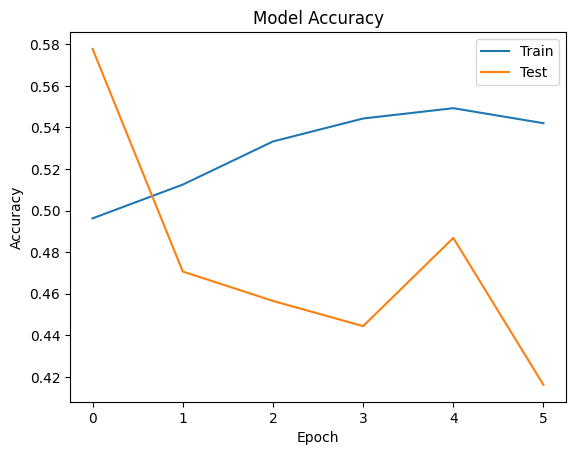

In [50]:
plot_loss_accuracy(history)

### d. Validate Model

In [51]:
model_mae = model.evaluate(X_test, y_test, verbose=0)

print(f'Model Accuracy {model_mae[1]:.4f}')

Model Accuracy 0.4979


## 4 Optimising Basic Model

### a. LSTM

In [54]:
%time

# Model hyperparameters
num_layers = [1, 2, 3] # 2, 2, 2, 2
layer_sizes = [50, 60, 70, 80] # 50, 60, 80, 70
batch_sizes = [64, 128] # 128, 64, 64, 128
learning_rates = [0.1, 1.0, 2.0] # 0.1, 1, 2, 0.1
epochs = [50, 60, 70, 80] # 50, 60, 50, 80
activ_func = 'relu'

best_model = None
best_performance = 0.0
best_weights = 0.0
best_hyperparameters = {}
count = 0

# Iterate over hyperparameter combinations
for num_layer in num_layers:
    for layer_size in layer_sizes:
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                for epoch in epochs:
                    count += 1
                    # Build the LSTM model
                    model = Sequential()
                    
                    # Add the specified number of LSTM layers
                    for _ in range(num_layer):
                        model.add(LSTM(layer_size, activation=activ_func, input_shape=(5, X_train.shape[-1]), return_sequences=True))
                    
                    # Flatten if there are multiple LSTM layers
                    if num_layer > 1:
                        model.add(Flatten())
                    
                    # Output layer
                    model.add(Dense(1, activation='sigmoid'))
                    
                    # Compile the model
                    optimizer = Adam(learning_rate=learning_rate)
                    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
                    
                    # Print model summary
                    print(model.summary())
                    
                    # Train the model
                    es = EarlyStopping(patience=5, restore_best_weights=True)
                    history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2, callbacks=[es], verbose=2)
                    
                    val_performance = history.history['val_accuracy'][-1]
                    
                    # Check if this configuration is the best so far
                    if val_performance > best_performance:
                        best_performance = val_performance
                        best_model = model
                        best_hyperparameters = {
                            'num_layer': num_layer,
                            'layer_size': layer_size,
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'epochs': epoch
                        }

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.11 µs
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_2 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 1.0806 - accuracy: 0.5213 - val_loss: 0.7726 - val_accuracy: 0.5192 - 541ms/epoch - 42ms/step
Epoch 2/50
13/13 - 0s - loss: 0.7574 - accuracy: 0.5038 - val_loss: 0.8236 - val_accuracy: 0.4727 - 37ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 0.7194 - accuracy: 0.5574 - val_loss: 0.8042 - val_accuracy: 0.4646 -

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_3 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 1.1214 - accuracy: 0.4985 - val_loss: 0.8895 - val_accuracy: 0.5152 - 564ms/epoch - 43ms/step
Epoch 2/60
13/13 - 0s - loss: 0.7442 - accuracy: 0.5178 - val_loss: 1.0395 - val_accuracy: 0.4768 - 35ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 0.7109 - accuracy: 0.5467 - val_loss: 0.8592 - val_accuracy: 0.4919 - 34ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 0.6868 - ac

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_4 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 1.1236 - accuracy: 0.4929 - val_loss: 0.7779 - val_accuracy: 0.4970 - 549ms/epoch - 42ms/step
Epoch 2/70
13/13 - 0s - loss: 0.7476 - accuracy: 0.5259 - val_loss: 1.0313 - val_accuracy: 0.4747 - 36ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 0.7107 - accuracy: 0.5297 - val_loss: 0.7116 - val_accuracy: 0.4970 - 35ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 0.6905 - ac

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_5 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 1.1461 - accuracy: 0.5173 - val_loss: 0.7727 - val_accuracy: 0.4616 - 644ms/epoch - 50ms/step
Epoch 2/80
13/13 - 0s - loss: 0.7217 - accuracy: 0.5183 - val_loss: 0.7462 - val_accuracy: 0.5091 - 36ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 0.7009 - accuracy: 0.5287 - val_loss: 0.7590 - val_accuracy: 0.4758 - 36ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 0.6815 - ac

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_6 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 7.1872 - accuracy: 0.4934 - val_loss: 7.9262 - val_accuracy: 0.4838 - 537ms/epoch - 41ms/step
Epoch 2/50
13/13 - 0s - loss: 7.4225 - accuracy: 0.5147 - val_loss: 7.7022 - val_accuracy: 0.4970 - 35ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 7.6468 - accuracy: 0.4992 - val_loss: 7.7363 - val_accuracy: 0.4939 - 37ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2459 - ac

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_7 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.5621 - accuracy: 0.4650 - val_loss: 7.1625 - val_accuracy: 0.5303 - 530ms/epoch - 41ms/step
Epoch 2/60
13/13 - 0s - loss: 8.1045 - accuracy: 0.4685 - val_loss: 7.1625 - val_accuracy: 0.5303 - 35ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 8.1045 - accuracy: 0.4685 - val_loss: 7.1625 - val_accuracy: 0.5303 - 35ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 8.1045 - ac

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_8 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.7955 - accuracy: 0.5132 - val_loss: 8.1799 - val_accuracy: 0.4697 - 528ms/epoch - 41ms/step
Epoch 2/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 33ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 34ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 7.2231 - ac

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 5, 50)             15600     
                                                                 
 dense_9 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 7.1833 - accuracy: 0.5005 - val_loss: 7.7023 - val_accuracy: 0.4980 - 535ms/epoch - 41ms/step
Epoch 2/80
13/13 - 0s - loss: 7.5901 - accuracy: 0.5061 - val_loss: 7.8797 - val_accuracy: 0.4869 - 33ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.3651 - accuracy: 0.5213 - val_loss: 8.0078 - val_accuracy: 0.4798 - 35ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 7.2966 - a

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_10 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 7.4669 - accuracy: 0.4784 - val_loss: 7.1625 - val_accuracy: 0.5303 - 535ms/epoch - 41ms/step
Epoch 2/50
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 35ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 35ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 8.1084 - a

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_11 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.4662 - accuracy: 0.4731 - val_loss: 7.1957 - val_accuracy: 0.5283 - 531ms/epoch - 41ms/step
Epoch 2/60
13/13 - 0s - loss: 8.0816 - accuracy: 0.4701 - val_loss: 7.2107 - val_accuracy: 0.5273 - 35ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 8.0816 - accuracy: 0.4701 - val_loss: 7.2263 - val_accuracy: 0.5263 - 34ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 8.0420 - a

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_12 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 7.5691 - accuracy: 0.4657 - val_loss: 7.1625 - val_accuracy: 0.5303 - 686ms/epoch - 53ms/step
Epoch 2/70
13/13 - 0s - loss: 8.1162 - accuracy: 0.4678 - val_loss: 7.1625 - val_accuracy: 0.5303 - 34ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 8.1162 - accuracy: 0.4678 - val_loss: 7.1625 - val_accuracy: 0.5303 - 36ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 8.1162 - a

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_13 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 6.7474 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 533ms/epoch - 41ms/step
Epoch 2/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 36ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 35ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 7.2231 - a

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_14 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 1.4287 - accuracy: 0.4698 - val_loss: 0.8409 - val_accuracy: 0.5020 - 523ms/epoch - 75ms/step
Epoch 2/50
7/7 - 0s - loss: 0.7636 - accuracy: 0.5310 - val_loss: 0.9648 - val_accuracy: 0.4636 - 27ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 0.7229 - accuracy: 0.5404 - val_loss: 0.8390 - val_accuracy: 0.4798 - 28ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 0.7051 - accuracy:

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_15 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 1.7083 - accuracy: 0.4901 - val_loss: 1.0909 - val_accuracy: 0.4788 - 520ms/epoch - 74ms/step
Epoch 2/60
7/7 - 0s - loss: 0.7785 - accuracy: 0.5183 - val_loss: 0.8263 - val_accuracy: 0.4636 - 28ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 0.7227 - accuracy: 0.5373 - val_loss: 0.8953 - val_accuracy: 0.4768 - 27ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 0.7178 - accuracy:

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_16 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 1.5310 - accuracy: 0.4952 - val_loss: 1.0617 - val_accuracy: 0.5283 - 521ms/epoch - 74ms/step
Epoch 2/70
7/7 - 0s - loss: 0.8074 - accuracy: 0.5063 - val_loss: 0.9667 - val_accuracy: 0.4636 - 26ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 0.7351 - accuracy: 0.5335 - val_loss: 0.7724 - val_accuracy: 0.5040 - 28ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 0.6970 - accuracy:

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_17 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 1.7640 - accuracy: 0.5071 - val_loss: 0.7180 - val_accuracy: 0.4889 - 525ms/epoch - 75ms/step
Epoch 2/80
7/7 - 0s - loss: 0.7241 - accuracy: 0.5426 - val_loss: 0.7973 - val_accuracy: 0.4909 - 28ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 0.7261 - accuracy: 0.5320 - val_loss: 0.8286 - val_accuracy: 0.4929 - 28ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 0.6922 - accuracy:

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_18 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.0370 - accuracy: 0.5254 - val_loss: 7.8916 - val_accuracy: 0.4848 - 531ms/epoch - 76ms/step
Epoch 2/50
7/7 - 0s - loss: 7.2469 - accuracy: 0.5294 - val_loss: 8.0330 - val_accuracy: 0.4778 - 29ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.2588 - accuracy: 0.5292 - val_loss: 7.9506 - val_accuracy: 0.4838 - 28ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 7.2398 - accuracy:

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_19 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 6.1626 - accuracy: 0.5190 - val_loss: 8.0934 - val_accuracy: 0.4747 - 524ms/epoch - 75ms/step
Epoch 2/60
7/7 - 0s - loss: 7.1906 - accuracy: 0.5338 - val_loss: 8.1625 - val_accuracy: 0.4697 - 27ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 7.1829 - accuracy: 0.5340 - val_loss: 8.0813 - val_accuracy: 0.4758 - 28ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 7.2223 - accuracy:

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_20 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 7.0452 - accuracy: 0.4607 - val_loss: 7.1625 - val_accuracy: 0.5303 - 690ms/epoch - 99ms/step
Epoch 2/70
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 28ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 27ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 8.1084 - accuracy:

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_21 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 6.0868 - accuracy: 0.5277 - val_loss: 8.1799 - val_accuracy: 0.4697 - 526ms/epoch - 75ms/step
Epoch 2/80
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 27ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 28ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 7.2231 - accuracy:

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_22 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.2743 - accuracy: 0.5061 - val_loss: 8.2440 - val_accuracy: 0.4646 - 522ms/epoch - 75ms/step
Epoch 2/50
7/7 - 0s - loss: 7.3103 - accuracy: 0.5256 - val_loss: 8.2192 - val_accuracy: 0.4667 - 28ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.3526 - accuracy: 0.5228 - val_loss: 8.1875 - val_accuracy: 0.4687 - 28ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 7.3639 - accuracy:

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_23 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 7.1184 - accuracy: 0.4480 - val_loss: 7.1625 - val_accuracy: 0.5303 - 555ms/epoch - 79ms/step
Epoch 2/60
7/7 - 0s - loss: 8.1472 - accuracy: 0.4657 - val_loss: 7.1625 - val_accuracy: 0.5303 - 28ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 8.0010 - accuracy: 0.4756 - val_loss: 7.1625 - val_accuracy: 0.5303 - 28ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 8.0102 - accuracy:

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_24 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 6.6602 - accuracy: 0.4952 - val_loss: 7.2266 - val_accuracy: 0.5263 - 527ms/epoch - 75ms/step
Epoch 2/70
7/7 - 0s - loss: 7.1953 - accuracy: 0.5294 - val_loss: 7.1960 - val_accuracy: 0.5283 - 28ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.2558 - accuracy: 0.5261 - val_loss: 7.2337 - val_accuracy: 0.5263 - 29ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 7.2810 - accuracy:

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 5, 50)             15600     
                                                                 
 dense_25 (Dense)            (None, 5, 1)              51        
                                                                 
Total params: 15651 (61.14 KB)
Trainable params: 15651 (61.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 6.3723 - accuracy: 0.5297 - val_loss: 8.1792 - val_accuracy: 0.4697 - 556ms/epoch - 79ms/step
Epoch 2/80
7/7 - 0s - loss: 7.2754 - accuracy: 0.5279 - val_loss: 8.2254 - val_accuracy: 0.4667 - 28ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 7.2678 - accuracy: 0.5284 - val_loss: 8.1631 - val_accuracy: 0.4707 - 28ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 7.2943 - accuracy:

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_26 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 1.3466 - accuracy: 0.5056 - val_loss: 0.8661 - val_accuracy: 0.5192 - 557ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 0.7432 - accuracy: 0.5066 - val_loss: 0.7566 - val_accuracy: 0.4828 - 40ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 0.7364 - accuracy: 0.5269 - val_loss: 0.7333 - val_accuracy: 0.4838 - 39ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 0.7104 - a

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_27 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 1.3442 - accuracy: 0.5254 - val_loss: 0.7586 - val_accuracy: 0.5091 - 561ms/epoch - 43ms/step
Epoch 2/60
13/13 - 0s - loss: 0.7724 - accuracy: 0.5251 - val_loss: 0.8601 - val_accuracy: 0.4970 - 39ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 0.7091 - accuracy: 0.5421 - val_loss: 0.7806 - val_accuracy: 0.5101 - 40ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 0.7084 - a

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_28 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 1.3142 - accuracy: 0.5135 - val_loss: 0.7640 - val_accuracy: 0.5333 - 553ms/epoch - 43ms/step
Epoch 2/70
13/13 - 0s - loss: 0.7511 - accuracy: 0.5183 - val_loss: 0.8730 - val_accuracy: 0.4596 - 39ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 0.7137 - accuracy: 0.5650 - val_loss: 0.9296 - val_accuracy: 0.4707 - 40ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 0.7060 - a

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_29 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 1.2771 - accuracy: 0.5079 - val_loss: 0.8388 - val_accuracy: 0.5202 - 739ms/epoch - 57ms/step
Epoch 2/80
13/13 - 0s - loss: 0.7802 - accuracy: 0.5211 - val_loss: 0.7250 - val_accuracy: 0.5091 - 39ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 0.7203 - accuracy: 0.5338 - val_loss: 0.8588 - val_accuracy: 0.4475 - 38ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 0.6959 - a

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_30 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 6.6273 - accuracy: 0.5327 - val_loss: 8.1799 - val_accuracy: 0.4697 - 563ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 7.2269 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 40ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 7.2269 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 40ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2269 - a

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_31 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.4919 - accuracy: 0.4728 - val_loss: 7.1625 - val_accuracy: 0.5303 - 552ms/epoch - 42ms/step
Epoch 2/60
13/13 - 0s - loss: 8.1063 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 46ms/epoch - 4ms/step
Epoch 3/60
13/13 - 0s - loss: 7.9678 - accuracy: 0.4777 - val_loss: 7.1482 - val_accuracy: 0.5313 - 45ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 8.0009 - a

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_32 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 7.6611 - accuracy: 0.4673 - val_loss: 7.1625 - val_accuracy: 0.5303 - 539ms/epoch - 41ms/step
Epoch 2/70
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 39ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 39ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 8.1084 - a

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_33 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 6.8754 - accuracy: 0.5195 - val_loss: 8.1470 - val_accuracy: 0.4717 - 533ms/epoch - 41ms/step
Epoch 2/80
13/13 - 0s - loss: 7.2699 - accuracy: 0.5277 - val_loss: 8.1944 - val_accuracy: 0.4687 - 39ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.2453 - accuracy: 0.5297 - val_loss: 8.1301 - val_accuracy: 0.4727 - 40ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 7.1867 - a

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_34 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 6.8138 - accuracy: 0.5297 - val_loss: 8.1799 - val_accuracy: 0.4697 - 572ms/epoch - 44ms/step
Epoch 2/50
13/13 - 0s - loss: 7.2265 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 40ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 7.2265 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 39ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2265 - a

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_35 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.5026 - accuracy: 0.4759 - val_loss: 7.1625 - val_accuracy: 0.5303 - 531ms/epoch - 41ms/step
Epoch 2/60
13/13 - 0s - loss: 8.1712 - accuracy: 0.4642 - val_loss: 7.1625 - val_accuracy: 0.5303 - 39ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 8.1282 - accuracy: 0.4680 - val_loss: 7.1625 - val_accuracy: 0.5303 - 40ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 7.5002 - a

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_36 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.7467 - accuracy: 0.5282 - val_loss: 8.1487 - val_accuracy: 0.4717 - 540ms/epoch - 42ms/step
Epoch 2/70
13/13 - 0s - loss: 7.2096 - accuracy: 0.5322 - val_loss: 8.1084 - val_accuracy: 0.4737 - 40ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 7.2266 - accuracy: 0.5310 - val_loss: 8.1013 - val_accuracy: 0.4737 - 38ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 7.2081 - a

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_37 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 6.6555 - accuracy: 0.5353 - val_loss: 8.1799 - val_accuracy: 0.4697 - 541ms/epoch - 42ms/step
Epoch 2/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 40ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 39ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 7.2231 - a

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_38 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 1.8168 - accuracy: 0.4865 - val_loss: 0.7726 - val_accuracy: 0.5000 - 549ms/epoch - 78ms/step
Epoch 2/50
7/7 - 0s - loss: 0.7540 - accuracy: 0.5175 - val_loss: 0.8634 - val_accuracy: 0.4859 - 30ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 0.7263 - accuracy: 0.5231 - val_loss: 0.8074 - val_accuracy: 0.4808 - 30ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 0.7192 - accuracy:

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_39 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 2.2307 - accuracy: 0.4980 - val_loss: 0.8185 - val_accuracy: 0.5152 - 535ms/epoch - 76ms/step
Epoch 2/60
7/7 - 0s - loss: 0.7687 - accuracy: 0.5289 - val_loss: 0.9379 - val_accuracy: 0.4929 - 29ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 0.7438 - accuracy: 0.5317 - val_loss: 0.7729 - val_accuracy: 0.5263 - 30ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 0.7072 - accuracy:

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_40 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 2.1406 - accuracy: 0.5069 - val_loss: 1.3251 - val_accuracy: 0.4677 - 772ms/epoch - 110ms/step
Epoch 2/70
7/7 - 0s - loss: 0.8474 - accuracy: 0.5327 - val_loss: 0.8141 - val_accuracy: 0.5182 - 31ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 0.7396 - accuracy: 0.5168 - val_loss: 0.9092 - val_accuracy: 0.4717 - 30ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 0.7351 - accuracy

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_41 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 1.7422 - accuracy: 0.4980 - val_loss: 0.7513 - val_accuracy: 0.4838 - 540ms/epoch - 77ms/step
Epoch 2/80
7/7 - 0s - loss: 0.7452 - accuracy: 0.5132 - val_loss: 0.8185 - val_accuracy: 0.4899 - 29ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 0.7293 - accuracy: 0.5307 - val_loss: 0.7744 - val_accuracy: 0.4859 - 28ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 0.7163 - accuracy:

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_42 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.1620 - accuracy: 0.5244 - val_loss: 8.1799 - val_accuracy: 0.4697 - 547ms/epoch - 78ms/step
Epoch 2/50
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 31ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 29ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 7.2231 - accuracy:

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_43 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 5.9853 - accuracy: 0.5452 - val_loss: 8.1799 - val_accuracy: 0.4697 - 534ms/epoch - 76ms/step
Epoch 2/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 7.2231 - accuracy:

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_44 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 7.0471 - accuracy: 0.4541 - val_loss: 7.2406 - val_accuracy: 0.5253 - 549ms/epoch - 78ms/step
Epoch 2/70
7/7 - 0s - loss: 7.8800 - accuracy: 0.4835 - val_loss: 7.3713 - val_accuracy: 0.5162 - 30ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.9771 - accuracy: 0.4772 - val_loss: 7.2061 - val_accuracy: 0.5273 - 29ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 7.9640 - accuracy:

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_45 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 7.0412 - accuracy: 0.4670 - val_loss: 7.1625 - val_accuracy: 0.5303 - 527ms/epoch - 75ms/step
Epoch 2/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 30ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 29ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 8.1084 - accuracy:

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_46 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.1330 - accuracy: 0.5368 - val_loss: 8.1799 - val_accuracy: 0.4697 - 554ms/epoch - 79ms/step
Epoch 2/50
7/7 - 0s - loss: 7.2385 - accuracy: 0.5307 - val_loss: 8.1799 - val_accuracy: 0.4697 - 31ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.2308 - accuracy: 0.5312 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 4/50
7/7 - 0s - loss: 7.2308 - accuracy:

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_47 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 6.2024 - accuracy: 0.5218 - val_loss: 8.1799 - val_accuracy: 0.4697 - 539ms/epoch - 77ms/step
Epoch 2/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 29ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 29ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 7.2231 - accuracy:

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_48 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 6.3396 - accuracy: 0.4987 - val_loss: 8.1799 - val_accuracy: 0.4697 - 533ms/epoch - 76ms/step
Epoch 2/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 29ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 7.2231 - accuracy:

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_49 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 6.8437 - accuracy: 0.4739 - val_loss: 7.2116 - val_accuracy: 0.5273 - 544ms/epoch - 78ms/step
Epoch 2/80
7/7 - 0s - loss: 7.9256 - accuracy: 0.4807 - val_loss: 7.2121 - val_accuracy: 0.5273 - 30ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 7.9470 - accuracy: 0.4797 - val_loss: 7.1967 - val_accuracy: 0.5283 - 29ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 7.9032 - accuracy:

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_50 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 1.3952 - accuracy: 0.4934 - val_loss: 1.5315 - val_accuracy: 0.4495 - 541ms/epoch - 42ms/step
Epoch 2/50
13/13 - 0s - loss: 0.7345 - accuracy: 0.5398 - val_loss: 0.9460 - val_accuracy: 0.5061 - 41ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 0.7363 - accuracy: 0.5457 - val_loss: 0.8010 - val_accuracy: 0.4919 - 42ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 0.7180 -

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_51 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 1.3488 - accuracy: 0.4970 - val_loss: 1.3685 - val_accuracy: 0.5192 - 560ms/epoch - 43ms/step
Epoch 2/60
13/13 - 0s - loss: 0.8149 - accuracy: 0.5071 - val_loss: 0.7917 - val_accuracy: 0.4990 - 43ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 0.7264 - accuracy: 0.5464 - val_loss: 0.8069 - val_accuracy: 0.4747 - 45ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 0.7070 -

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_52 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 1.1569 - accuracy: 0.5074 - val_loss: 0.8086 - val_accuracy: 0.5545 - 536ms/epoch - 41ms/step
Epoch 2/70
13/13 - 0s - loss: 0.7695 - accuracy: 0.5157 - val_loss: 0.7433 - val_accuracy: 0.4970 - 42ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 0.7129 - accuracy: 0.5429 - val_loss: 0.7660 - val_accuracy: 0.4727 - 41ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 0.7062 -

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_53 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 1.2551 - accuracy: 0.5135 - val_loss: 0.8557 - val_accuracy: 0.4859 - 850ms/epoch - 65ms/step
Epoch 2/80
13/13 - 0s - loss: 0.7758 - accuracy: 0.5254 - val_loss: 0.8221 - val_accuracy: 0.5192 - 41ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 0.7197 - accuracy: 0.5330 - val_loss: 0.9133 - val_accuracy: 0.4899 - 41ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 0.7200 -

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_54 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 6.7322 - accuracy: 0.5236 - val_loss: 8.1799 - val_accuracy: 0.4697 - 563ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 45ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 46ms/epoch - 4ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2231 -

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_55 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.7176 - accuracy: 0.4678 - val_loss: 7.1625 - val_accuracy: 0.5303 - 536ms/epoch - 41ms/step
Epoch 2/60
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 42ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 41ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 8.1084 -

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_56 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.7923 - accuracy: 0.5150 - val_loss: 7.4871 - val_accuracy: 0.5101 - 553ms/epoch - 43ms/step
Epoch 2/70
13/13 - 0s - loss: 7.9932 - accuracy: 0.4766 - val_loss: 7.3488 - val_accuracy: 0.5192 - 45ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 7.9525 - accuracy: 0.4794 - val_loss: 7.3332 - val_accuracy: 0.5202 - 45ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 7.9486 -

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_57 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 7.4052 - accuracy: 0.4741 - val_loss: 7.4112 - val_accuracy: 0.5152 - 568ms/epoch - 44ms/step
Epoch 2/80
13/13 - 0s - loss: 7.9223 - accuracy: 0.4810 - val_loss: 7.4127 - val_accuracy: 0.5152 - 41ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.9031 - accuracy: 0.4822 - val_loss: 7.4287 - val_accuracy: 0.5141 - 43ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 7.8727 -

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_58 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 7.5464 - accuracy: 0.4685 - val_loss: 7.1625 - val_accuracy: 0.5303 - 559ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 45ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 45ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 8.1084 -

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_59 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 6.8294 - accuracy: 0.5201 - val_loss: 8.1799 - val_accuracy: 0.4697 - 554ms/epoch - 43ms/step
Epoch 2/60
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 42ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 43ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 7.2231 -

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_60 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.6538 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 538ms/epoch - 41ms/step
Epoch 2/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 42ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 41ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 7.2231 -

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_61 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 7.4335 - accuracy: 0.4820 - val_loss: 7.2280 - val_accuracy: 0.5263 - 576ms/epoch - 44ms/step
Epoch 2/80
13/13 - 0s - loss: 7.9336 - accuracy: 0.4810 - val_loss: 7.1257 - val_accuracy: 0.5333 - 42ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 8.0567 - accuracy: 0.4739 - val_loss: 7.3472 - val_accuracy: 0.5192 - 42ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 8.0134 -

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_62 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 1.7850 - accuracy: 0.4962 - val_loss: 0.9406 - val_accuracy: 0.4636 - 533ms/epoch - 76ms/step
Epoch 2/50
7/7 - 0s - loss: 0.8137 - accuracy: 0.5109 - val_loss: 0.7974 - val_accuracy: 0.5061 - 32ms/epoch - 5ms/step
Epoch 3/50
7/7 - 0s - loss: 0.7563 - accuracy: 0.5178 - val_loss: 0.8134 - val_accuracy: 0.4879 - 32ms/epoch - 5ms/step
Epoch 4/50
7/7 - 0s - loss: 0.7135 - accurac

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_63 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 1.7580 - accuracy: 0.4957 - val_loss: 0.9215 - val_accuracy: 0.5182 - 555ms/epoch - 79ms/step
Epoch 2/60
7/7 - 0s - loss: 0.8614 - accuracy: 0.4888 - val_loss: 1.4638 - val_accuracy: 0.5374 - 31ms/epoch - 4ms/step
Epoch 3/60
7/7 - 0s - loss: 0.8024 - accuracy: 0.5150 - val_loss: 0.8588 - val_accuracy: 0.4606 - 32ms/epoch - 5ms/step
Epoch 4/60
7/7 - 0s - loss: 0.7246 - accurac

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_64 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 2.0845 - accuracy: 0.5109 - val_loss: 2.9626 - val_accuracy: 0.4727 - 551ms/epoch - 79ms/step
Epoch 2/70
7/7 - 0s - loss: 0.9435 - accuracy: 0.5188 - val_loss: 1.4948 - val_accuracy: 0.5394 - 30ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 0.8030 - accuracy: 0.5228 - val_loss: 0.8309 - val_accuracy: 0.5101 - 33ms/epoch - 5ms/step
Epoch 4/70
7/7 - 0s - loss: 0.7614 - accurac

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_65 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 1.5996 - accuracy: 0.5137 - val_loss: 0.7873 - val_accuracy: 0.5101 - 530ms/epoch - 76ms/step
Epoch 2/80
7/7 - 0s - loss: 0.7616 - accuracy: 0.4980 - val_loss: 0.8769 - val_accuracy: 0.4970 - 32ms/epoch - 5ms/step
Epoch 3/80
7/7 - 0s - loss: 0.7575 - accuracy: 0.5277 - val_loss: 0.7860 - val_accuracy: 0.4788 - 33ms/epoch - 5ms/step
Epoch 4/80
7/7 - 0s - loss: 0.6967 - accurac

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_66 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.6877 - accuracy: 0.4909 - val_loss: 7.6686 - val_accuracy: 0.5010 - 548ms/epoch - 78ms/step
Epoch 2/50
7/7 - 0s - loss: 7.2443 - accuracy: 0.5294 - val_loss: 7.9077 - val_accuracy: 0.4869 - 31ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.2665 - accuracy: 0.5284 - val_loss: 7.8920 - val_accuracy: 0.4879 - 32ms/epoch - 5ms/step
Epoch 4/50
7/7 - 0s - loss: 7.2705 - accurac

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_67 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 6.3105 - accuracy: 0.5327 - val_loss: 8.0669 - val_accuracy: 0.4768 - 534ms/epoch - 76ms/step
Epoch 2/60
7/7 - 0s - loss: 7.2060 - accuracy: 0.5327 - val_loss: 7.9568 - val_accuracy: 0.4838 - 34ms/epoch - 5ms/step
Epoch 3/60
7/7 - 0s - loss: 7.2066 - accuracy: 0.5325 - val_loss: 8.0193 - val_accuracy: 0.4798 - 33ms/epoch - 5ms/step
Epoch 4/60
7/7 - 0s - loss: 7.2010 - accurac

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_68 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 6.3023 - accuracy: 0.5081 - val_loss: 8.1799 - val_accuracy: 0.4697 - 925ms/epoch - 132ms/step
Epoch 2/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 31ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 32ms/epoch - 5ms/step
Epoch 4/70
7/7 - 0s - loss: 7.2231 - accura

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_69 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 7.1025 - accuracy: 0.4594 - val_loss: 7.1625 - val_accuracy: 0.5303 - 561ms/epoch - 80ms/step
Epoch 2/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 33ms/epoch - 5ms/step
Epoch 3/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 33ms/epoch - 5ms/step
Epoch 4/80
7/7 - 0s - loss: 8.1084 - accurac

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_70 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.2806 - accuracy: 0.5183 - val_loss: 8.1799 - val_accuracy: 0.4697 - 530ms/epoch - 76ms/step
Epoch 2/50
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 31ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 32ms/epoch - 5ms/step
Epoch 4/50
7/7 - 0s - loss: 7.2231 - accurac

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_71 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_71 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 6.2011 - accuracy: 0.5246 - val_loss: 8.1799 - val_accuracy: 0.4697 - 561ms/epoch - 80ms/step
Epoch 2/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 32ms/epoch - 5ms/step
Epoch 3/60
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 4/60
7/7 - 0s - loss: 7.2231 - accurac

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_72 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 6.2217 - accuracy: 0.5147 - val_loss: 8.1799 - val_accuracy: 0.4697 - 538ms/epoch - 77ms/step
Epoch 2/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 30ms/epoch - 4ms/step
Epoch 4/70
7/7 - 0s - loss: 7.2231 - accurac

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 5, 70)             27440     
                                                                 
 dense_73 (Dense)            (None, 5, 1)              71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 7.1769 - accuracy: 0.4647 - val_loss: 7.1937 - val_accuracy: 0.5283 - 535ms/epoch - 76ms/step
Epoch 2/80
7/7 - 0s - loss: 8.0852 - accuracy: 0.4698 - val_loss: 7.1937 - val_accuracy: 0.5283 - 31ms/epoch - 4ms/step
Epoch 3/80
7/7 - 0s - loss: 8.0892 - accuracy: 0.4695 - val_loss: 7.1937 - val_accuracy: 0.5283 - 31ms/epoch - 4ms/step
Epoch 4/80
7/7 - 0s - loss: 8.0853 - accurac

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_74 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 1.5281 - accuracy: 0.5127 - val_loss: 0.7952 - val_accuracy: 0.5253 - 549ms/epoch - 42ms/step
Epoch 2/50
13/13 - 0s - loss: 0.7508 - accuracy: 0.5330 - val_loss: 0.7444 - val_accuracy: 0.5172 - 44ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 0.7280 - accuracy: 0.5266 - val_loss: 0.7857 - val_accuracy: 0.4838 - 43ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 0.7099 -

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_75 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 1.5296 - accuracy: 0.5096 - val_loss: 0.9075 - val_accuracy: 0.4899 - 553ms/epoch - 43ms/step
Epoch 2/60
13/13 - 0s - loss: 0.7770 - accuracy: 0.5231 - val_loss: 0.7667 - val_accuracy: 0.5020 - 44ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 0.7124 - accuracy: 0.5162 - val_loss: 0.7411 - val_accuracy: 0.4828 - 45ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 0.7011 -

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_76 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 2.4559 - accuracy: 0.5058 - val_loss: 0.8563 - val_accuracy: 0.4687 - 545ms/epoch - 42ms/step
Epoch 2/70
13/13 - 0s - loss: 0.8368 - accuracy: 0.5041 - val_loss: 0.8967 - val_accuracy: 0.5303 - 43ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 0.7945 - accuracy: 0.5157 - val_loss: 0.7713 - val_accuracy: 0.5091 - 45ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 0.7031 -

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_77 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 1.2668 - accuracy: 0.5348 - val_loss: 0.9634 - val_accuracy: 0.5020 - 537ms/epoch - 41ms/step
Epoch 2/80
13/13 - 0s - loss: 0.7910 - accuracy: 0.5119 - val_loss: 0.9212 - val_accuracy: 0.5535 - 44ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 0.7234 - accuracy: 0.5411 - val_loss: 0.7933 - val_accuracy: 0.4929 - 44ms/epoch - 3ms/step
Epoch 4/80
13/13 - 0s - loss: 0.6864 -

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_78 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 6.7712 - accuracy: 0.5244 - val_loss: 8.1799 - val_accuracy: 0.4697 - 561ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 45ms/epoch - 3ms/step
Epoch 3/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 44ms/epoch - 3ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2231 -

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_79 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_79 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 7.6983 - accuracy: 0.4556 - val_loss: 7.1625 - val_accuracy: 0.5303 - 539ms/epoch - 41ms/step
Epoch 2/60
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 44ms/epoch - 3ms/step
Epoch 3/60
13/13 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 43ms/epoch - 3ms/step
Epoch 4/60
13/13 - 0s - loss: 8.1084 -

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_80 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.6726 - accuracy: 0.5345 - val_loss: 8.1799 - val_accuracy: 0.4697 - 564ms/epoch - 43ms/step
Epoch 2/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 44ms/epoch - 3ms/step
Epoch 3/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 45ms/epoch - 3ms/step
Epoch 4/70
13/13 - 0s - loss: 7.2231 -

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_81 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 6.7324 - accuracy: 0.5231 - val_loss: 8.1799 - val_accuracy: 0.4697 - 558ms/epoch - 43ms/step
Epoch 2/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 44ms/epoch - 3ms/step
Epoch 3/80
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 58ms/epoch - 4ms/step
Epoch 4/80
13/13 - 0s - loss: 7.2231 -

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_82 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 - 1s - loss: 6.6538 - accuracy: 0.5312 - val_loss: 8.1799 - val_accuracy: 0.4697 - 553ms/epoch - 43ms/step
Epoch 2/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 46ms/epoch - 4ms/step
Epoch 3/50
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 48ms/epoch - 4ms/step
Epoch 4/50
13/13 - 0s - loss: 7.2231 -

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_83 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_83 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
13/13 - 1s - loss: 6.6761 - accuracy: 0.5320 - val_loss: 8.1799 - val_accuracy: 0.4697 - 569ms/epoch - 44ms/step
Epoch 2/60
13/13 - 0s - loss: 7.2270 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 47ms/epoch - 4ms/step
Epoch 3/60
13/13 - 0s - loss: 7.2270 - accuracy: 0.5315 - val_loss: 8.1799 - val_accuracy: 0.4697 - 47ms/epoch - 4ms/step
Epoch 4/60
13/13 - 0s - loss: 7.2270 -

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_84 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
13/13 - 1s - loss: 6.7125 - accuracy: 0.5272 - val_loss: 8.1799 - val_accuracy: 0.4697 - 572ms/epoch - 44ms/step
Epoch 2/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 47ms/epoch - 4ms/step
Epoch 3/70
13/13 - 0s - loss: 7.2231 - accuracy: 0.5317 - val_loss: 8.1799 - val_accuracy: 0.4697 - 48ms/epoch - 4ms/step
Epoch 4/70
13/13 - 0s - loss: 7.2231 -

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_85 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_85 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
13/13 - 1s - loss: 7.6058 - accuracy: 0.4632 - val_loss: 7.3168 - val_accuracy: 0.5212 - 1s/epoch - 87ms/step
Epoch 2/80
13/13 - 0s - loss: 8.0708 - accuracy: 0.4711 - val_loss: 7.3798 - val_accuracy: 0.5172 - 48ms/epoch - 4ms/step
Epoch 3/80
13/13 - 0s - loss: 8.0285 - accuracy: 0.4736 - val_loss: 7.3648 - val_accuracy: 0.5182 - 47ms/epoch - 4ms/step
Epoch 4/80
13/13 - 0s - loss: 8.0055 - ac

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_86 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_86 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 2.2443 - accuracy: 0.5170 - val_loss: 0.8694 - val_accuracy: 0.4616 - 565ms/epoch - 81ms/step
Epoch 2/50
7/7 - 0s - loss: 0.8415 - accuracy: 0.5165 - val_loss: 0.8519 - val_accuracy: 0.4798 - 34ms/epoch - 5ms/step
Epoch 3/50
7/7 - 0s - loss: 0.7552 - accuracy: 0.5107 - val_loss: 0.8680 - val_accuracy: 0.4828 - 33ms/epoch - 5ms/step
Epoch 4/50
7/7 - 0s - loss: 0.7123 - accurac

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_87 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_87 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 1.6456 - accuracy: 0.4916 - val_loss: 0.8106 - val_accuracy: 0.4818 - 546ms/epoch - 78ms/step
Epoch 2/60
7/7 - 0s - loss: 0.8086 - accuracy: 0.5180 - val_loss: 1.0486 - val_accuracy: 0.5222 - 33ms/epoch - 5ms/step
Epoch 3/60
7/7 - 0s - loss: 0.7862 - accuracy: 0.5086 - val_loss: 0.8351 - val_accuracy: 0.4939 - 33ms/epoch - 5ms/step
Epoch 4/60
7/7 - 0s - loss: 0.7018 - accurac

Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_88 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 2.0908 - accuracy: 0.5081 - val_loss: 0.8821 - val_accuracy: 0.4899 - 559ms/epoch - 80ms/step
Epoch 2/70
7/7 - 0s - loss: 0.7881 - accuracy: 0.5251 - val_loss: 1.0374 - val_accuracy: 0.4808 - 32ms/epoch - 5ms/step
Epoch 3/70
7/7 - 0s - loss: 0.7900 - accuracy: 0.5256 - val_loss: 0.8780 - val_accuracy: 0.4909 - 34ms/epoch - 5ms/step
Epoch 4/70
7/7 - 0s - loss: 0.7211 - accurac

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_89 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_89 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 1.9426 - accuracy: 0.5010 - val_loss: 1.5241 - val_accuracy: 0.5162 - 544ms/epoch - 78ms/step
Epoch 2/80
7/7 - 0s - loss: 0.8156 - accuracy: 0.5234 - val_loss: 1.0775 - val_accuracy: 0.5040 - 34ms/epoch - 5ms/step
Epoch 3/80
7/7 - 0s - loss: 0.7736 - accuracy: 0.5360 - val_loss: 0.9196 - val_accuracy: 0.4909 - 34ms/epoch - 5ms/step
Epoch 4/80
7/7 - 0s - loss: 0.7002 - accurac

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_90 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_90 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 - 1s - loss: 6.7495 - accuracy: 0.4772 - val_loss: 7.4791 - val_accuracy: 0.5111 - 538ms/epoch - 77ms/step
Epoch 2/50
7/7 - 0s - loss: 7.8989 - accuracy: 0.4838 - val_loss: 7.4836 - val_accuracy: 0.5111 - 31ms/epoch - 4ms/step
Epoch 3/50
7/7 - 0s - loss: 7.7160 - accuracy: 0.4962 - val_loss: 7.7935 - val_accuracy: 0.4919 - 32ms/epoch - 5ms/step
Epoch 4/50
7/7 - 0s - loss: 7.6144 - accurac

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_91 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_91 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
7/7 - 1s - loss: 6.2322 - accuracy: 0.5249 - val_loss: 8.0108 - val_accuracy: 0.4798 - 546ms/epoch - 78ms/step
Epoch 2/60
7/7 - 0s - loss: 7.3837 - accuracy: 0.5206 - val_loss: 7.9339 - val_accuracy: 0.4848 - 34ms/epoch - 5ms/step
Epoch 3/60
7/7 - 0s - loss: 7.4778 - accuracy: 0.5145 - val_loss: 7.9341 - val_accuracy: 0.4848 - 33ms/epoch - 5ms/step
Epoch 4/60
7/7 - 0s - loss: 7.3852 - accurac

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_92 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/70
7/7 - 1s - loss: 6.1711 - accuracy: 0.5211 - val_loss: 8.1799 - val_accuracy: 0.4697 - 551ms/epoch - 79ms/step
Epoch 2/70
7/7 - 0s - loss: 7.2298 - accuracy: 0.5310 - val_loss: 8.1799 - val_accuracy: 0.4697 - 31ms/epoch - 4ms/step
Epoch 3/70
7/7 - 0s - loss: 7.2186 - accuracy: 0.5320 - val_loss: 8.1799 - val_accuracy: 0.4697 - 33ms/epoch - 5ms/step
Epoch 4/70
7/7 - 0s - loss: 7.2438 - accurac

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_93 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_93 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/80
7/7 - 1s - loss: 7.0406 - accuracy: 0.4632 - val_loss: 7.1625 - val_accuracy: 0.5303 - 563ms/epoch - 80ms/step
Epoch 2/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 32ms/epoch - 5ms/step
Epoch 3/80
7/7 - 0s - loss: 8.1084 - accuracy: 0.4683 - val_loss: 7.1625 - val_accuracy: 0.5303 - 32ms/epoch - 5ms/step
Epoch 4/80
7/7 - 0s - loss: 8.1084 - accurac

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_94 (LSTM)              (None, 5, 80)             34560     
                                                                 
 dense_94 (Dense)            (None, 5, 1)              81        
                                                                 
Total params: 34641 (135.32 KB)
Trainable params: 34641 (135.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50


KeyboardInterrupt: 

In [55]:
best_model.summary()
print(f'Best Model Accuracy: {best_performance}')
print(f'Best Model Hyperparameters: {best_hyperparameters}')
print(f'Number of Model Iterations: {count}')

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 5, 60)             21120     
                                                                 
 dense_35 (Dense)            (None, 5, 1)              61        
                                                                 
Total params: 21181 (82.74 KB)
Trainable params: 21181 (82.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Best Model Accuracy: 0.5363636016845703
Best Model Hyperparameters: {'num_layer': 1, 'layer_size': 60, 'batch_size': 64, 'learning_rate': 2.0, 'epochs': 60}
Number of Model Iterations: 93


In [56]:
model_acc = best_model.evaluate(X_test, y_test, verbose=1)

print(f'Model Accuracy {model_acc[1]:.4f}')

8/8 [==============================] - 0s 1ms/step - loss: 7.0749 - accuracy: 0.5378
Model Accuracy 0.5378


### b. Graph

## 5 Ideas of model variations

GRU, Bidirectional, Transformers, data time dimention, feature selection, overfitting, hyperperameter selection, sentimental analysis, 
merging features
 - Regularization such as dropout layer
 - decay rate
 - weight initialisation
 - momentum
 - layer normalization
 - Feed-forward layers